# Create Embeddings from the data you provide using Multi instance learining model
[Multimil API](https://multimil.readthedocs.io/en/latest/index.html)\
[Tutorial](https://multimil.readthedocs.io/en/latest/notebooks/paired_integration_cite-seq.html)
## Implementing the multimil.model.MultiVAE model

In [1]:
#Import the packages needed
import anndata as ad
import multimil as mtm
import muon
import scanpy as sc
import scvi
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

Global seed set to 0


In [2]:
#checking compatable version of scvi model and setting the seed 0 for the randon no generator
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Global seed set to 0


Last run with scvi-tools version: 0.20.3


## Loading and prerrocessing data

In [13]:
# load your data in my case its from the data from  10_subset_blood_query_data.R
adata=sc.read_h5ad("/Users/gp/Desktop/MultiMil/dataset_20_20.h5ad")
adata

AnnData object with n_obs × n_vars = 114718 × 33105
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', '

In [41]:
# taking a subset to speed up training time
sc.pp.subsample(adata, n_obs=20000)
adata

AnnData object with n_obs × n_vars = 20000 × 33105
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'c

In [45]:
rna=adata.copy()

In [46]:
rna

AnnData object with n_obs × n_vars = 20000 × 33105
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'c

### log-normalize the raw counts and subset the RNA data to 2,000 highly variable genes.

In [47]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

### taking two samples out for the query data

In [49]:
rna.obs["sample_id"].unique()

['2acd118f895a16fe56496a7118aef5b2', '1c5b0fb1d172136c78e6e46a94fe59b9', '9a3bde6c5a7c925cf4dff6c8b17fea3e', 'b4936c4fb1c818e510649118ba4c16ff', 'b242dbe9a58fd9b9db5237b12a1d9bdc', ..., '53b18e8f9b9476afa8e43073241e80b1', '9acbba567ddf904d2c33059430ea83ba', '2ab8e9010d4ee13eafc3f891cb9df4e0', '6d35f9d656a50dbb8009d5069ddbc8e2', 'b26317effafb20b0d8c8a0a704ca8038']
Length: 20
Categories (20, object): ['1c5b0fb1d172136c78e6e46a94fe59b9', '2ab8e9010d4ee13eafc3f891cb9df4e0', '2acd118f895a16fe56496a7118aef5b2', '4c8846c46d4c5123bb1d569d8f65fb3b', ..., 'cbc6acba4581aa259b0082a8f6b9b492', 'cf8b6d5e72d68217680f117ab9f9e39f', 'ddc4114183b1dcc44a799a7b5bd34e6f', 'f12b4e0ee6584b3d46342f45f69e3d50']

In [57]:
rna.obs[["sample_id", "sex"]]

sample_id  \
CV001_KM10202389-CV001_KM10202399_CAGCCGAAGGGTT...  2acd118f895a16fe56496a7118aef5b2   
S19_CACATAGAGATGGGTC-1___2a498ace-872a-4935-984...  1c5b0fb1d172136c78e6e46a94fe59b9   
S21_AACCATGAGGTAAACT-1___2a498ace-872a-4935-984...  9a3bde6c5a7c925cf4dff6c8b17fea3e   
S4_CTGAAGTCAACTTGAC-1___2a498ace-872a-4935-984b...  b4936c4fb1c818e510649118ba4c16ff   
S19_ATTCTACTCCCAAGTA-1___2a498ace-872a-4935-984...  b242dbe9a58fd9b9db5237b12a1d9bdc   
...                                                                              ...   
S19_CAGAATCCAAAGTCAA-1___2a498ace-872a-4935-984...  9acbba567ddf904d2c33059430ea83ba   
S4_TTTGGTTCATCGATTG-1___2a498ace-872a-4935-984b...  cf8b6d5e72d68217680f117ab9f9e39f   
S4_CCTCAGTTCACCAGGC-1___2a498ace-872a-4935-984b...  cf8b6d5e72d68217680f117ab9f9e39f   
S6_TAAACCGTCACTCCTG-1___2a498ace-872a-4935-984b...  4c8846c46d4c5123bb1d569d8f65fb3b   
S21_TCTCTAACAAGTCTAC-1___2a498ace-872a-4935-984...  9a3bde6c5a7c925cf4dff6c8b17fea3e   

                                                       sex  
CV001_KM10202389-CV001_KM10202399_CAGCCGAAGGGTT...  female  
S19_CACATAGAGATGGGTC-1___2a498ace-872a-4935-984...    male  
S21_AACCATGAGGTAAACT-1___2a498ace-872a-4935-984...    male  
S4_CTGAAGTCAACTTGAC-1___2a498ace-872a-4935-984b...  female  
S19_ATTCTACTCCCAAGTA-1___2a498ace-872a-4935-984...    male  
...                                                    ...  
S19_CAGAATCCAAAGTCAA-1___2a498ace-872a-4935-984...  female  
S4_TTTGGTTCATCGATTG-1___2a498ace-872a-4935-984b...  female  
S4_CCTCAGTTCACCAGGC-1___2a498ace-872a-4935-984b...  female  
S6_TAAACCGTCACTCCTG-1___2a498ace-872a-4935-984b...    male  
S21_TCTCTAACAAGTCTAC-1___2a498ace-872a-4935-984...    male  

[20000 rows x 2 columns]

In [50]:
n_top_genes = 2000
batch_key = "sample_id"

In [51]:
#calculating highly variable genes
sc.pp.highly_variable_genes(rna, n_top_genes=n_top_genes, batch_key=batch_key, subset=True)
rna

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 20000 × 2000
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'ce

In [60]:
adata_formatted = mtm.data.organize_multimodal_anndatas(
    adatas=[[rna]],  # a list of anndata objects per modality, RNA-seq always goes first  # if need to use data from .layers, if None use .X
)
adata_formatted

AnnData object with n_obs × n_vars = 20000 × 2000
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'ce

### Current data come from 20 samples so taking 2 samples for the query

In [61]:
query = adata_formatted[adata_formatted.obs[batch_key] == "2acd118f895a16fe56496a7118aef5b2"].copy()
query = adata_formatted[adata_formatted.obs[batch_key] == "1c5b0fb1d172136c78e6e46a94fe59b9"].copy()
adata_formatted = adata_formatted[adata_formatted.obs[batch_key] != "2acd118f895a16fe56496a7118aef5b2"].copy()
adata_formatted = adata_formatted[adata_formatted.obs[batch_key] != "1c5b0fb1d172136c78e6e46a94fe59b9"].copy()
(adata_formatted, query)


(AnnData object with n_obs × n_vars = 17696 × 2000
     obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', '

In [62]:
rna_indices_end = rna.shape[1]

In [63]:
adata_formatted_sample=adata_formatted.copy()

In [65]:
adata_formatted_sample_sex=adata_formatted.copy()

In [66]:
# setup data without correcting any batch effect
mtm.model.MultiVAE.setup_anndata(
    adata_formatted,
    rna_indices_end=rna_indices_end,
)

In [64]:
#setting up anndata with sample_id as covariate key that batch effect in the data we want to correct
mtm.model.MultiVAE.setup_anndata(
    adata_formatted_sample,
    categorical_covariate_keys=[batch_key],
    rna_indices_end=rna_indices_end,
)

In [67]:
#setting up data with sample_id and sex
mtm.model.MultiVAE.setup_anndata(
    adata_formatted_sample_sex,
    categorical_covariate_keys=[batch_key,"sex"],
    rna_indices_end=rna_indices_end,
)

## Model setup 

In [68]:
#model with no batch effect correction
vae = mtm.model.MultiVAE(
    adata_formatted,
    losses=["nb"],
)

In [69]:
#model with sampleId batch effect correction
vae_sample = mtm.model.MultiVAE(
    adata_formatted_sample,
    losses=["nb"],
)

In [70]:
#model with sampleid and sex batch effect correction
vae_sample_sex = mtm.model.MultiVAE(
    adata_formatted_sample_sex,
    losses=["nb"],
)

## Training the model

In [71]:
vae.train(lr=1e-4)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [04:34<00:00,  2.42s/it, loss=556, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:34<00:00,  1.37s/it, loss=556, v_num=1]


In [74]:
vae_sample.train(lr=1e-4)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [04:54<00:00,  1.45s/it, loss=543, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:54<00:00,  1.47s/it, loss=543, v_num=1]


In [75]:
vae_sample_sex.train(lr=1e-4)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [04:41<00:00,  1.33s/it, loss=546, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:41<00:00,  1.41s/it, loss=546, v_num=1]


## Plotting Losses

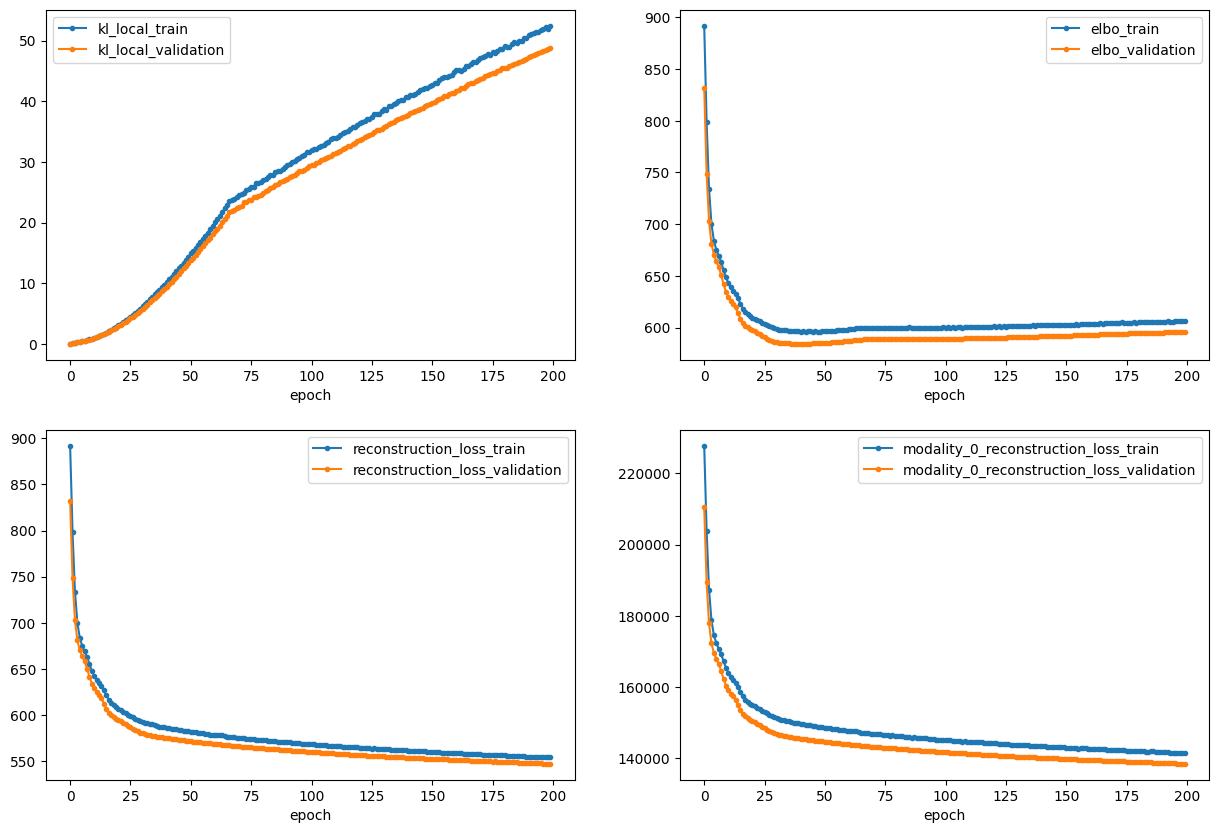

In [72]:
vae.plot_losses()

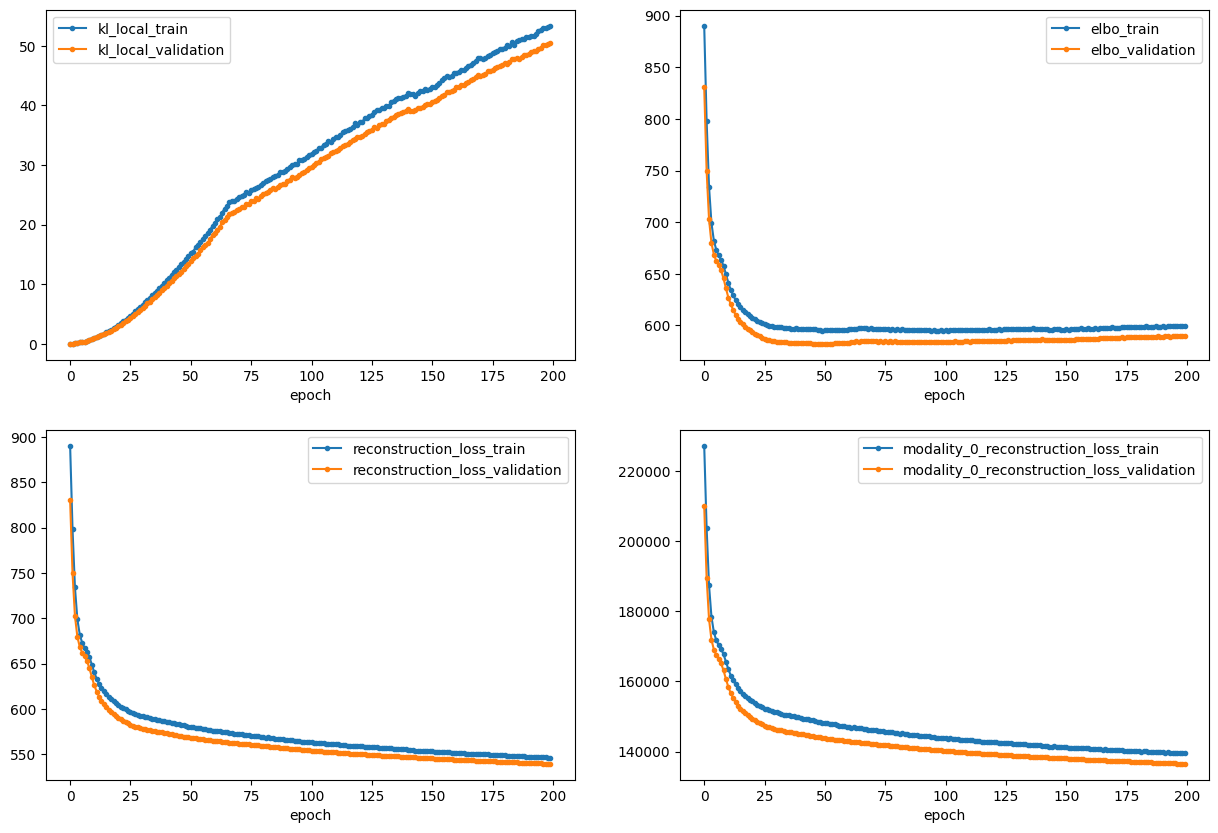

In [76]:
vae_sample.plot_losses()

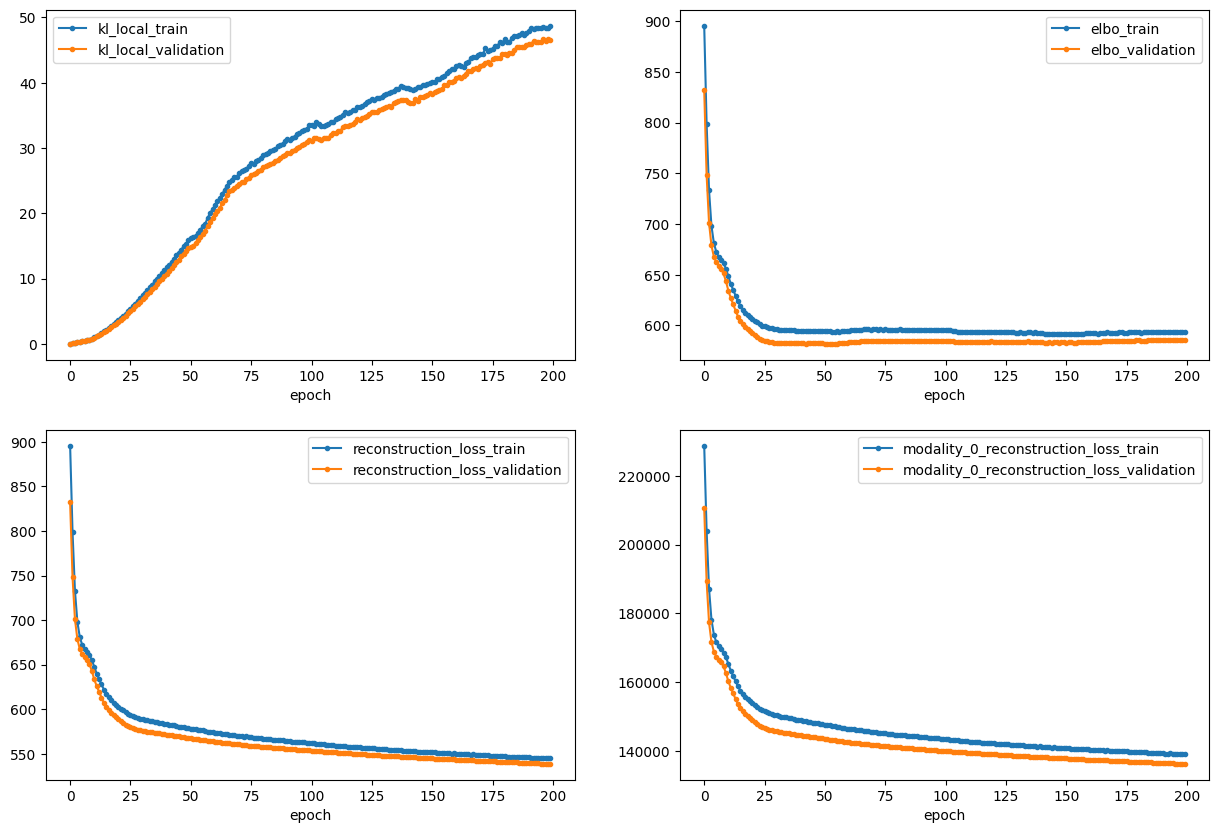

In [77]:
vae_sample_sex.plot_losses()

## Visualize the Latent space

In [73]:
vae.get_model_output()
adata_formatted

AnnData object with n_obs × n_vars = 17696 × 2000
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'ce

In [80]:
adata_formatted.obsm['X_multiMIL'].shape

(17696, 16)

In [81]:
vae_sample.get_model_output()
adata_formatted_sample

AnnData object with n_obs × n_vars = 17696 × 2000
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'ce

In [82]:
vae_sample_sex.get_model_output()
adata_formatted_sample_sex

AnnData object with n_obs × n_vars = 17696 × 2000
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'ce

In [83]:
#creating UMAP from scanpy
sc.pp.neighbors(adata_formatted, use_rep="X_multiMIL")
sc.tl.umap(adata_formatted)
sc.pp.neighbors(adata_formatted_sample, use_rep="X_multiMIL")
sc.tl.umap(adata_formatted_sample)
sc.pp.neighbors(adata_formatted_sample_sex, use_rep="X_multiMIL")
sc.tl.umap(adata_formatted_sample_sex)

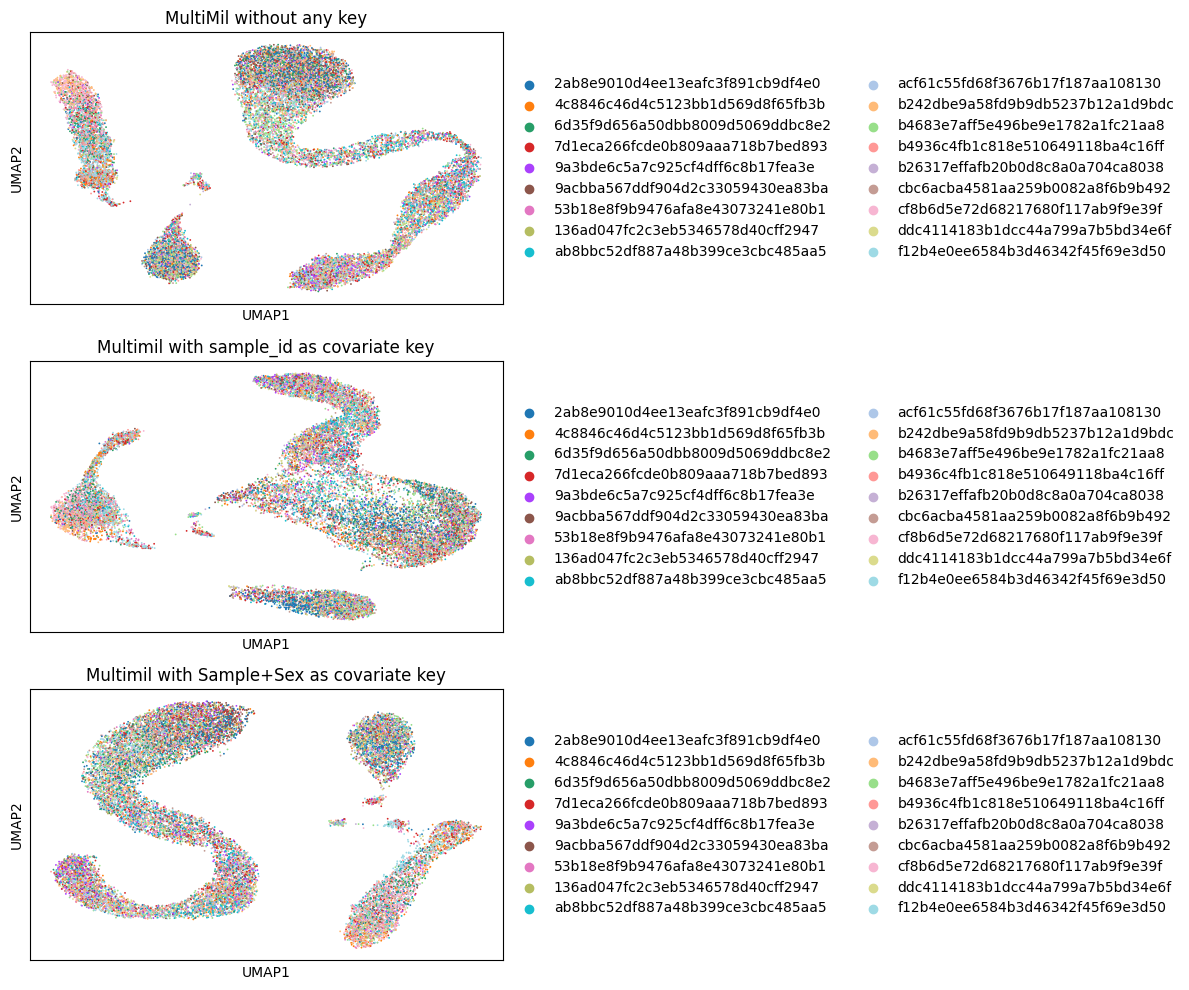

In [101]:
# Setup fig size and its orientation
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# First row: adata_formatted
sc.pl.umap(adata_formatted, color="sample_id", show=False, ax=axes[0], 
           title="MultiMil without any key")

# Second row: adata_formatted_sample
sc.pl.umap(adata_formatted_sample, color="sample_id", show=False, ax=axes[1], 
           title="Multimil with sample_id as covariate key")

# Third row: adata_formatted_sample_sex
sc.pl.umap(adata_formatted_sample_sex, color="sample_id", show=False, ax=axes[2], 
           title="Multimil with Sample+Sex as covariate key")

# Adjust layout
plt.tight_layout()
plt.show()

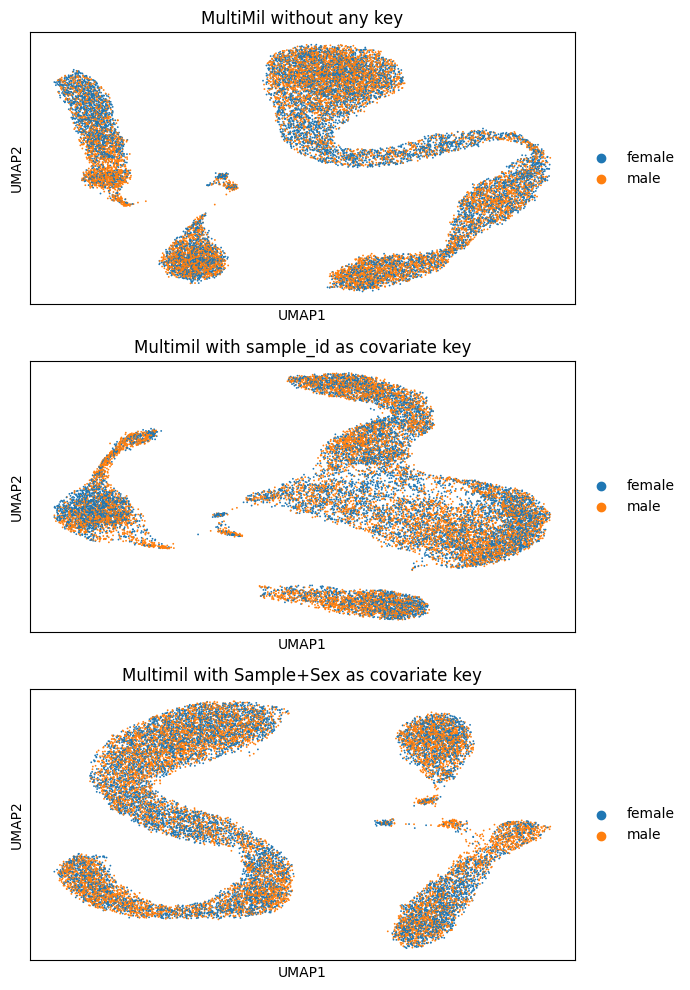

In [102]:
# Setup fig size and its orientation
fig, axes = plt.subplots(3, 1, figsize=(7, 10))

# First row: adata_formatted
sc.pl.umap(adata_formatted, color="sex", show=False, ax=axes[0], 
           title="MultiMil without any key")

# Second row: adata_formatted_sample
sc.pl.umap(adata_formatted_sample, color="sex", show=False, ax=axes[1], 
           title="Multimil with sample_id as covariate key")

# Third row: adata_formatted_sample_sex
sc.pl.umap(adata_formatted_sample_sex, color="sex", show=False, ax=axes[2], 
           title="Multimil with Sample+Sex as covariate key")

# Adjust layout
plt.tight_layout()
plt.show()

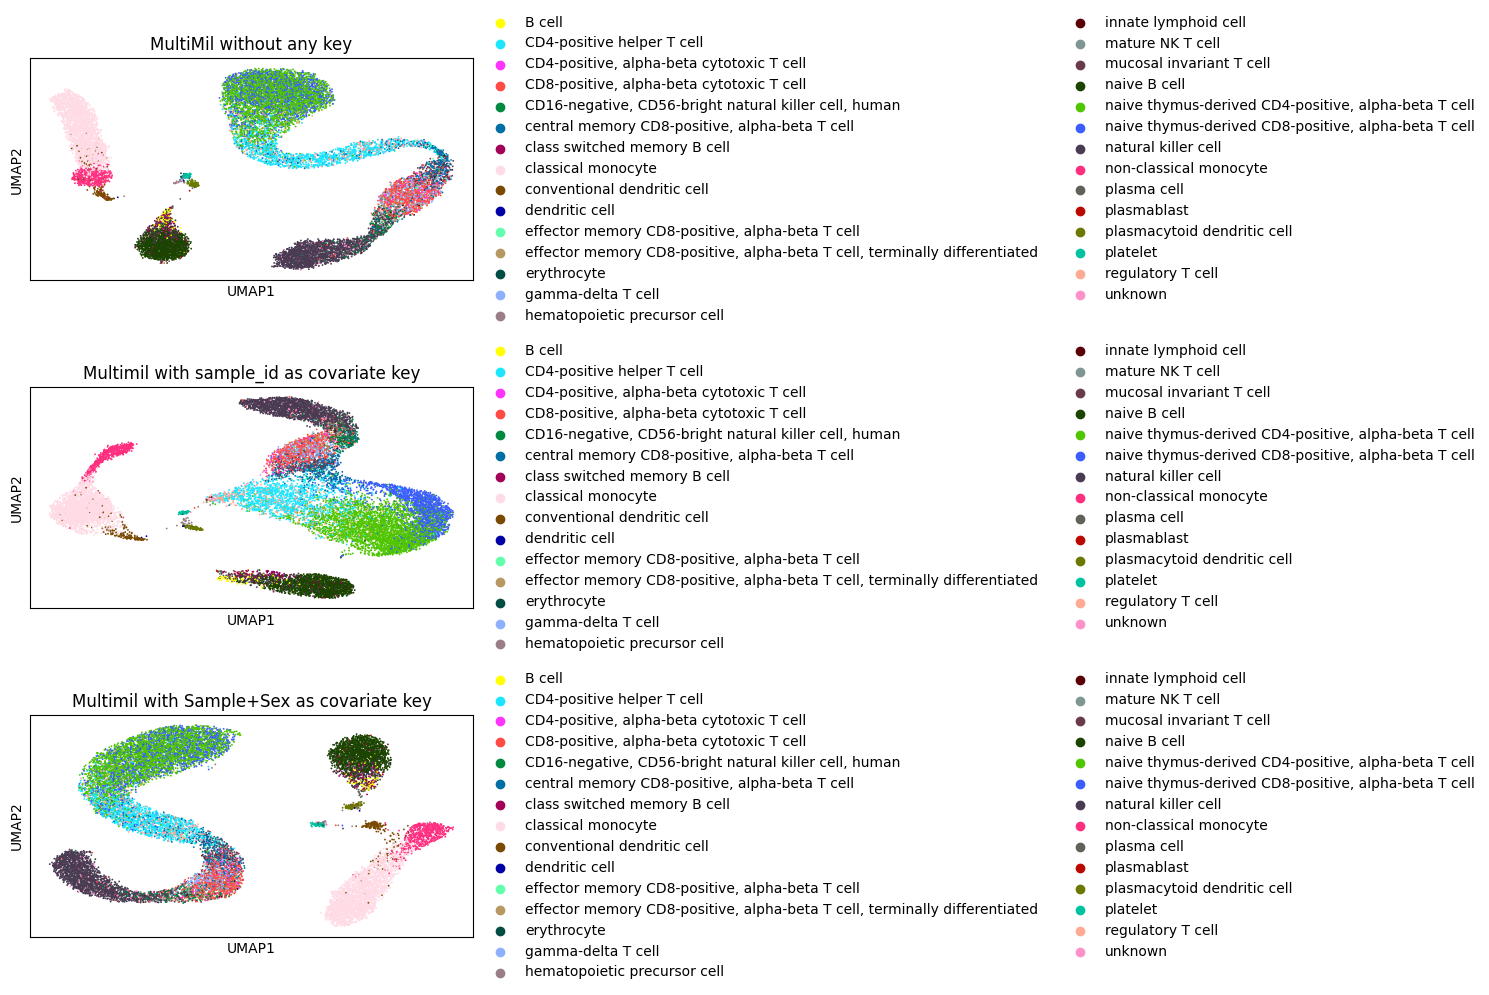

In [159]:
# Setup fig size and its orientation
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# First row: adata_formatted
sc.pl.umap(adata_formatted, color="cell_type", show=False, ax=axes[0], 
           title="MultiMil without any key")

# Second row: adata_formatted_sample
sc.pl.umap(adata_formatted_sample, color="cell_type", show=False, ax=axes[1], 
           title="Multimil with sample_id as covariate key")

# Third row: adata_formatted_sample_sex
sc.pl.umap(adata_formatted_sample_sex, color="cell_type", show=False, ax=axes[2], 
           title="Multimil with Sample+Sex as covariate key")

# Adjust layout
plt.tight_layout()
plt.show()

## Preparing the query

In [106]:
query_sample=query.copy()
query_sample_sex=query.copy()

In [162]:
new_vae_sample = mtm.model.MultiVAE.load_query_data(query_sample, reference_model=vae_sample)
new_vae_sample_sex = mtm.model.MultiVAE.load_query_data(query_sample_sex, reference_model=vae_sample_sex)

## Fine tunning the model on query

In [163]:
new_vae_sample.train(
    weight_decay=0,
)
new_vae_sample_sex.train(
    weight_decay=0,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [00:20<00:00,  9.99it/s, loss=577, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:20<00:00,  9.68it/s, loss=577, v_num=1]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Epoch 200/200: 100%|██████████| 200/200 [00:22<00:00,  8.84it/s, loss=574, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:22<00:00,  8.88it/s, loss=574, v_num=1]


###  Get the latent representation of the query

In [164]:
new_vae_sample.get_model_output(query_sample)
query_sample

AnnData object with n_obs × n_vars = 1077 × 2000
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'cel

In [165]:
new_vae_sample_sex.get_model_output(query_sample_sex)
query_sample_sex

AnnData object with n_obs × n_vars = 1077 × 2000
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'cel

In [166]:
adata_formatted_sample.obs["reference"] = "reference"
query_sample.obs["reference"] = "query"
adata_both_sample = ad.concat([adata_formatted_sample, query_sample])
adata_formatted_sample_sex.obs["reference"] = "reference"
query_sample_sex.obs["reference"] = "query"
adata_both_sample_sex = ad.concat([adata_formatted_sample_sex, query_sample_sex])
(adata_both_sample,adata_both_sample_sex)

(AnnData object with n_obs × n_vars = 18773 × 2000
     obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', '

In [167]:
sc.pp.neighbors(adata_both_sample, use_rep="X_multiMIL")
sc.tl.umap(adata_both_sample)
sc.pp.neighbors(adata_both_sample_sex, use_rep="X_multiMIL")
sc.tl.umap(adata_both_sample_sex)

### visualize both the reference and the query together.

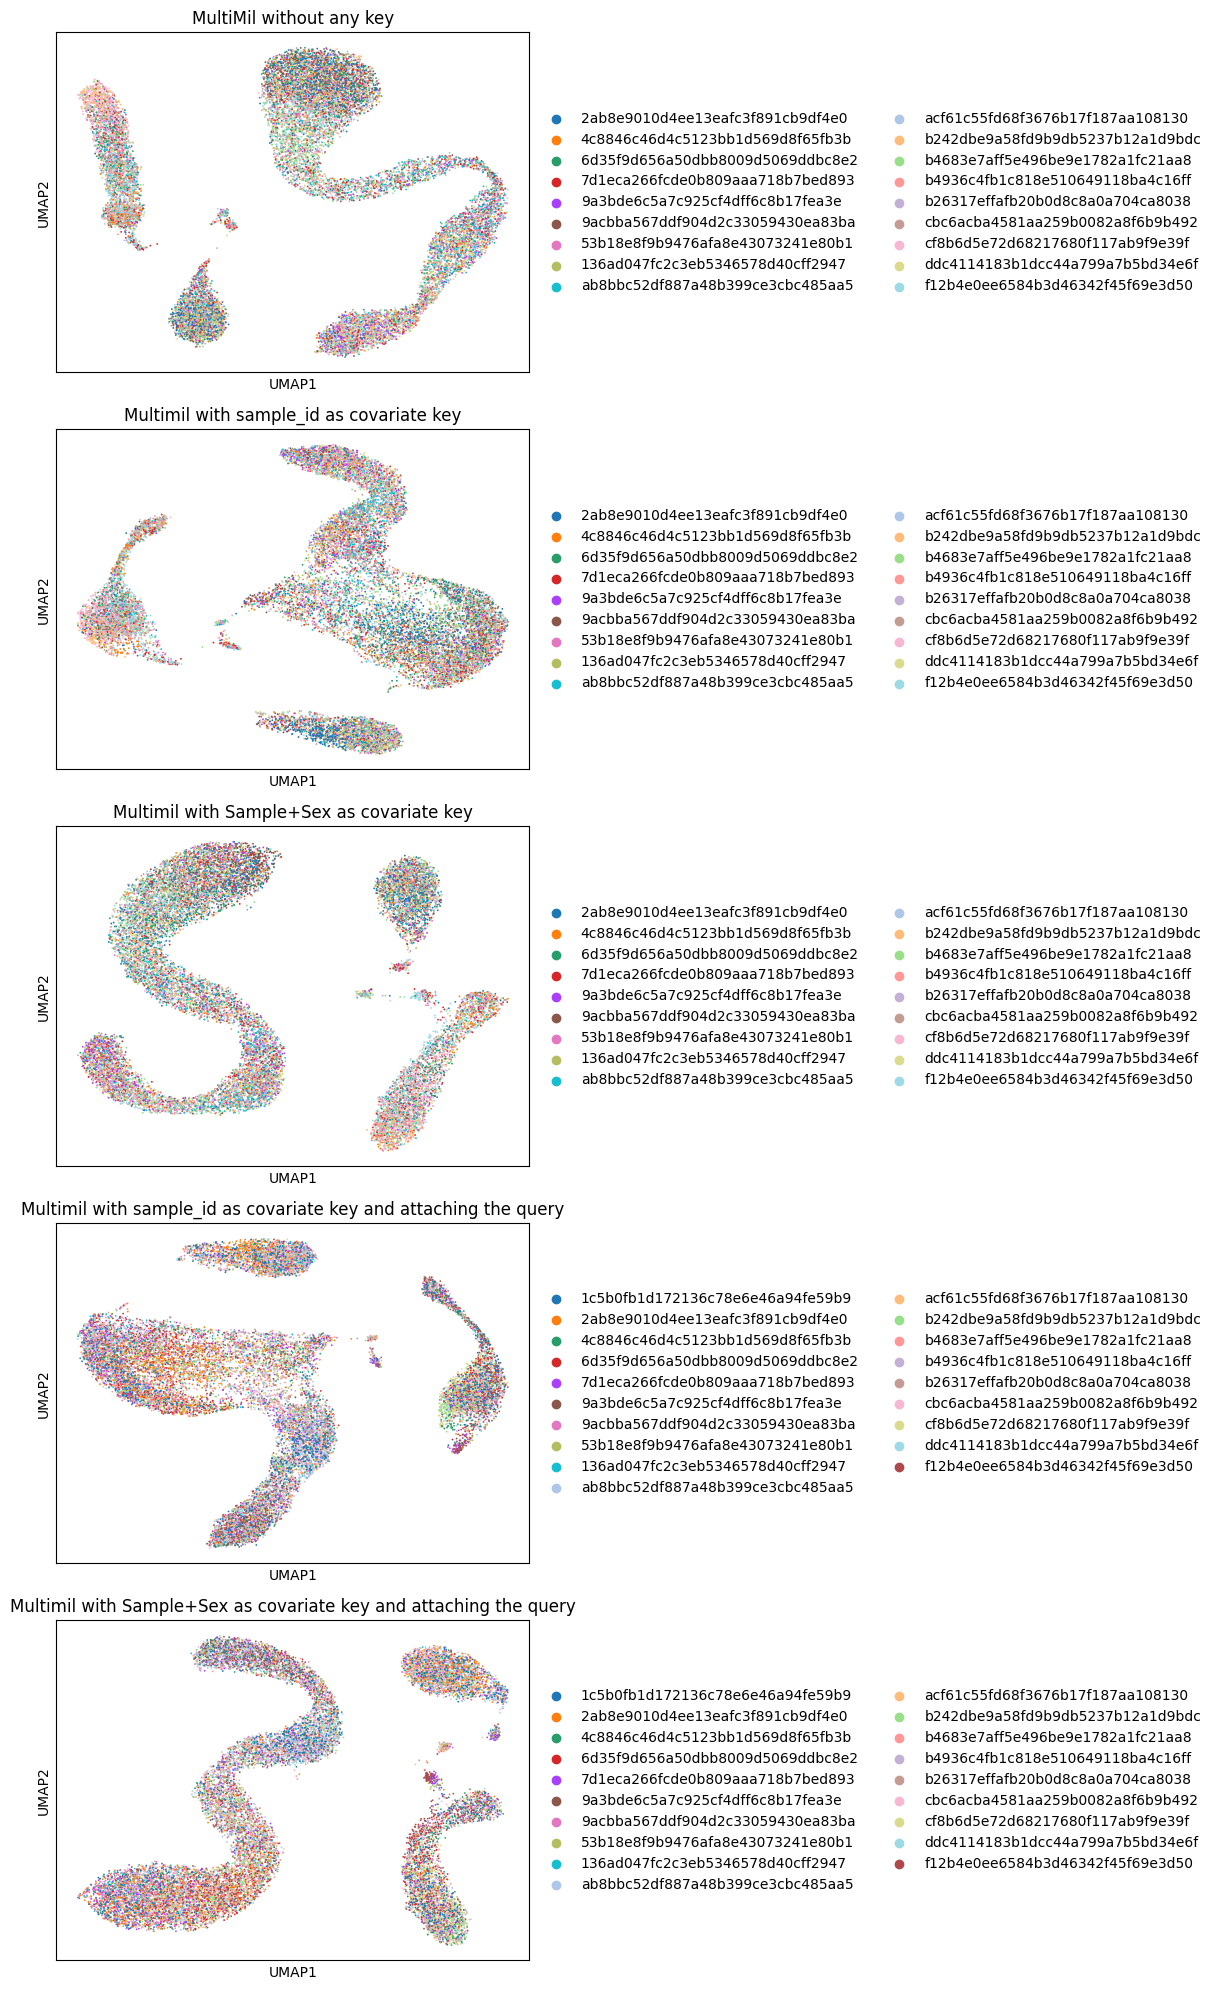

In [192]:
# Setup fig size and its orientation
fig, axes = plt.subplots(5, 1, figsize=(12, 20))

# First row
sc.pl.umap(adata_formatted, color="sample_id", show=False, ax=axes[0], 
           title="MultiMil without any key")

# Second row
sc.pl.umap(adata_formatted_sample, color="sample_id", show=False, ax=axes[1], 
           title="Multimil with sample_id as covariate key")

# Third row
sc.pl.umap(adata_formatted_sample_sex, color="sample_id", show=False, ax=axes[2], 
           title="Multimil with Sample+Sex as covariate key")
# Forth row
sc.pl.umap(adata_both_sample, color="sample_id", show=False, ax=axes[3], 
           title="Multimil with sample_id as covariate key and attaching the query")

# Fifth row
sc.pl.umap(adata_both_sample_sex, color="sample_id", show=False, ax=axes[4], 
           title="Multimil with Sample+Sex as covariate key and attaching the query")
# Adjust layout
plt.tight_layout()
plt.show()

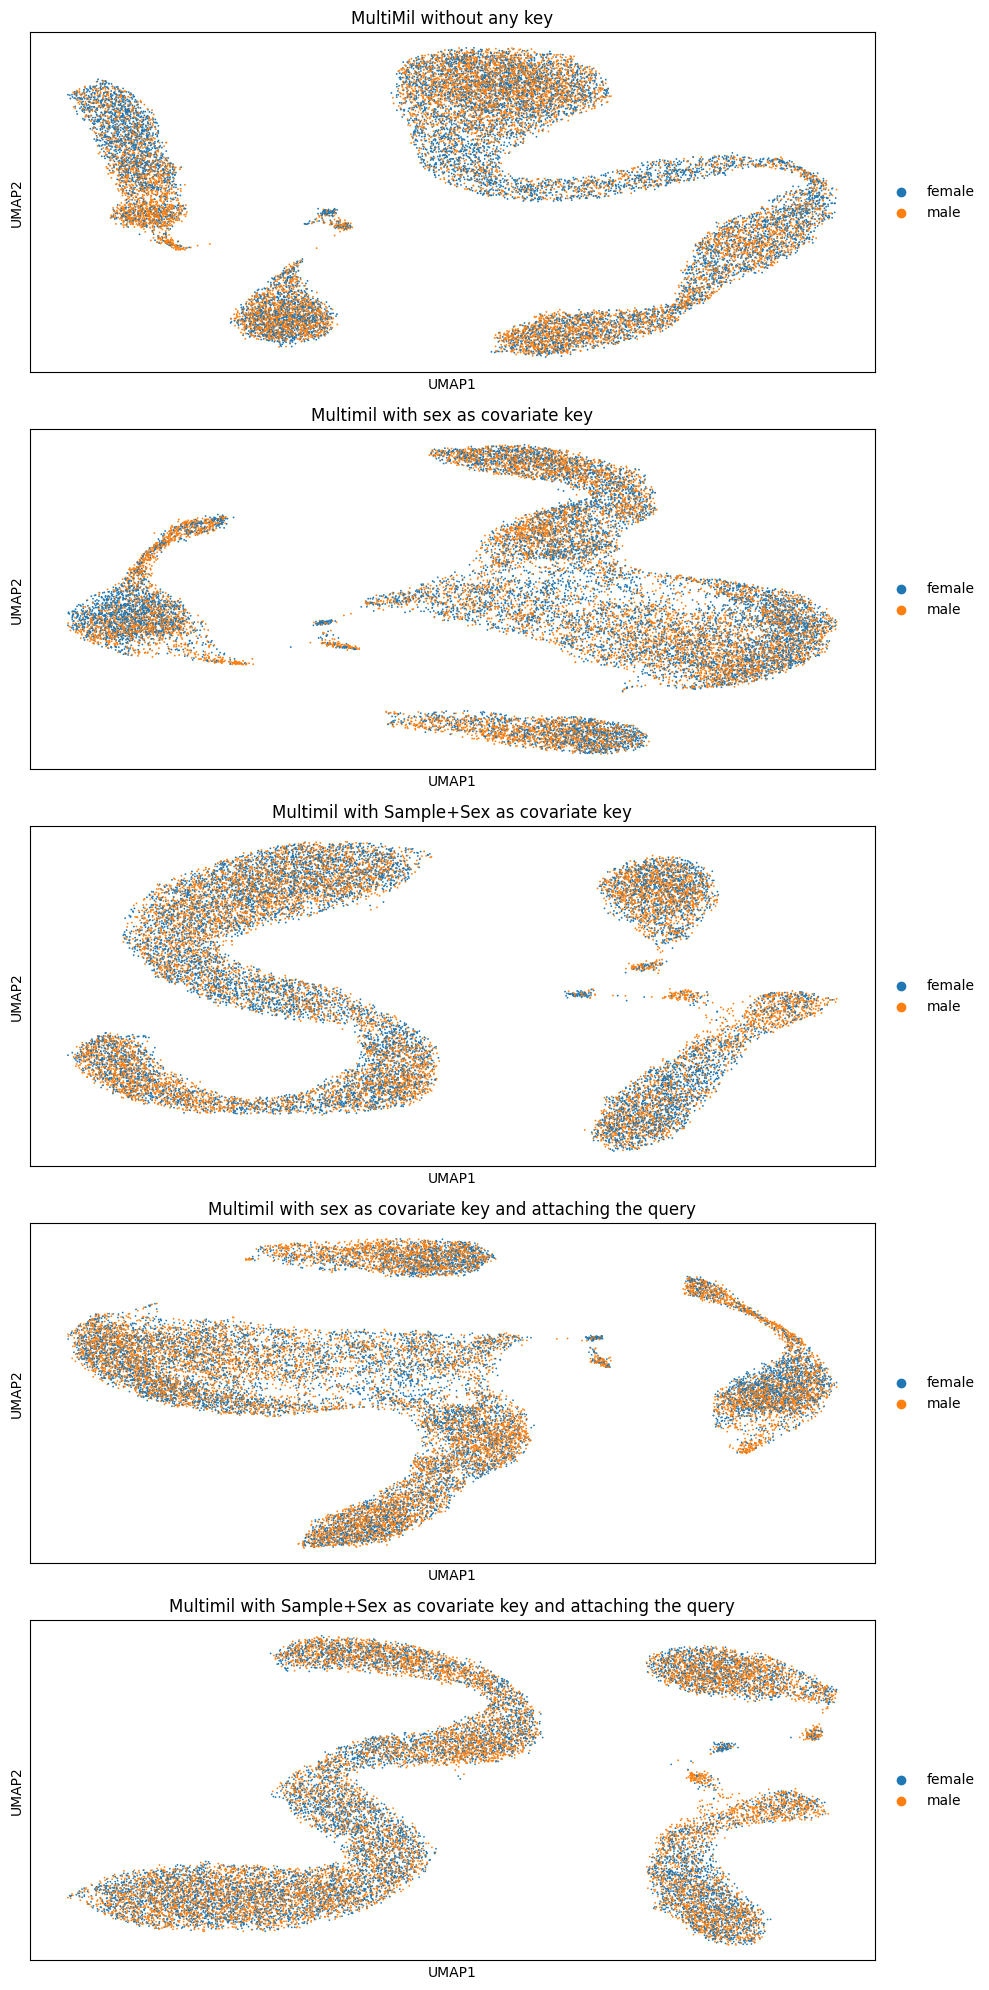

In [193]:
# Setup fig size and its orientation
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

# First row
sc.pl.umap(adata_formatted, color="sex", show=False, ax=axes[0], 
           title="MultiMil without any key")

# Second row
sc.pl.umap(adata_formatted_sample, color="sex", show=False, ax=axes[1], 
           title="Multimil with sex as covariate key")

# Third row
sc.pl.umap(adata_formatted_sample_sex, color="sex", show=False, ax=axes[2], 
           title="Multimil with Sample+Sex as covariate key")
# Fourth row
sc.pl.umap(adata_both_sample, color="sex", show=False, ax=axes[3], 
           title="Multimil with sex as covariate key and attaching the query")

# Fifth row
sc.pl.umap(adata_both_sample_sex, color="sex", show=False, ax=axes[4], 
           title="Multimil with Sample+Sex as covariate key and attaching the query")
# Adjust layout
plt.tight_layout()
plt.show()

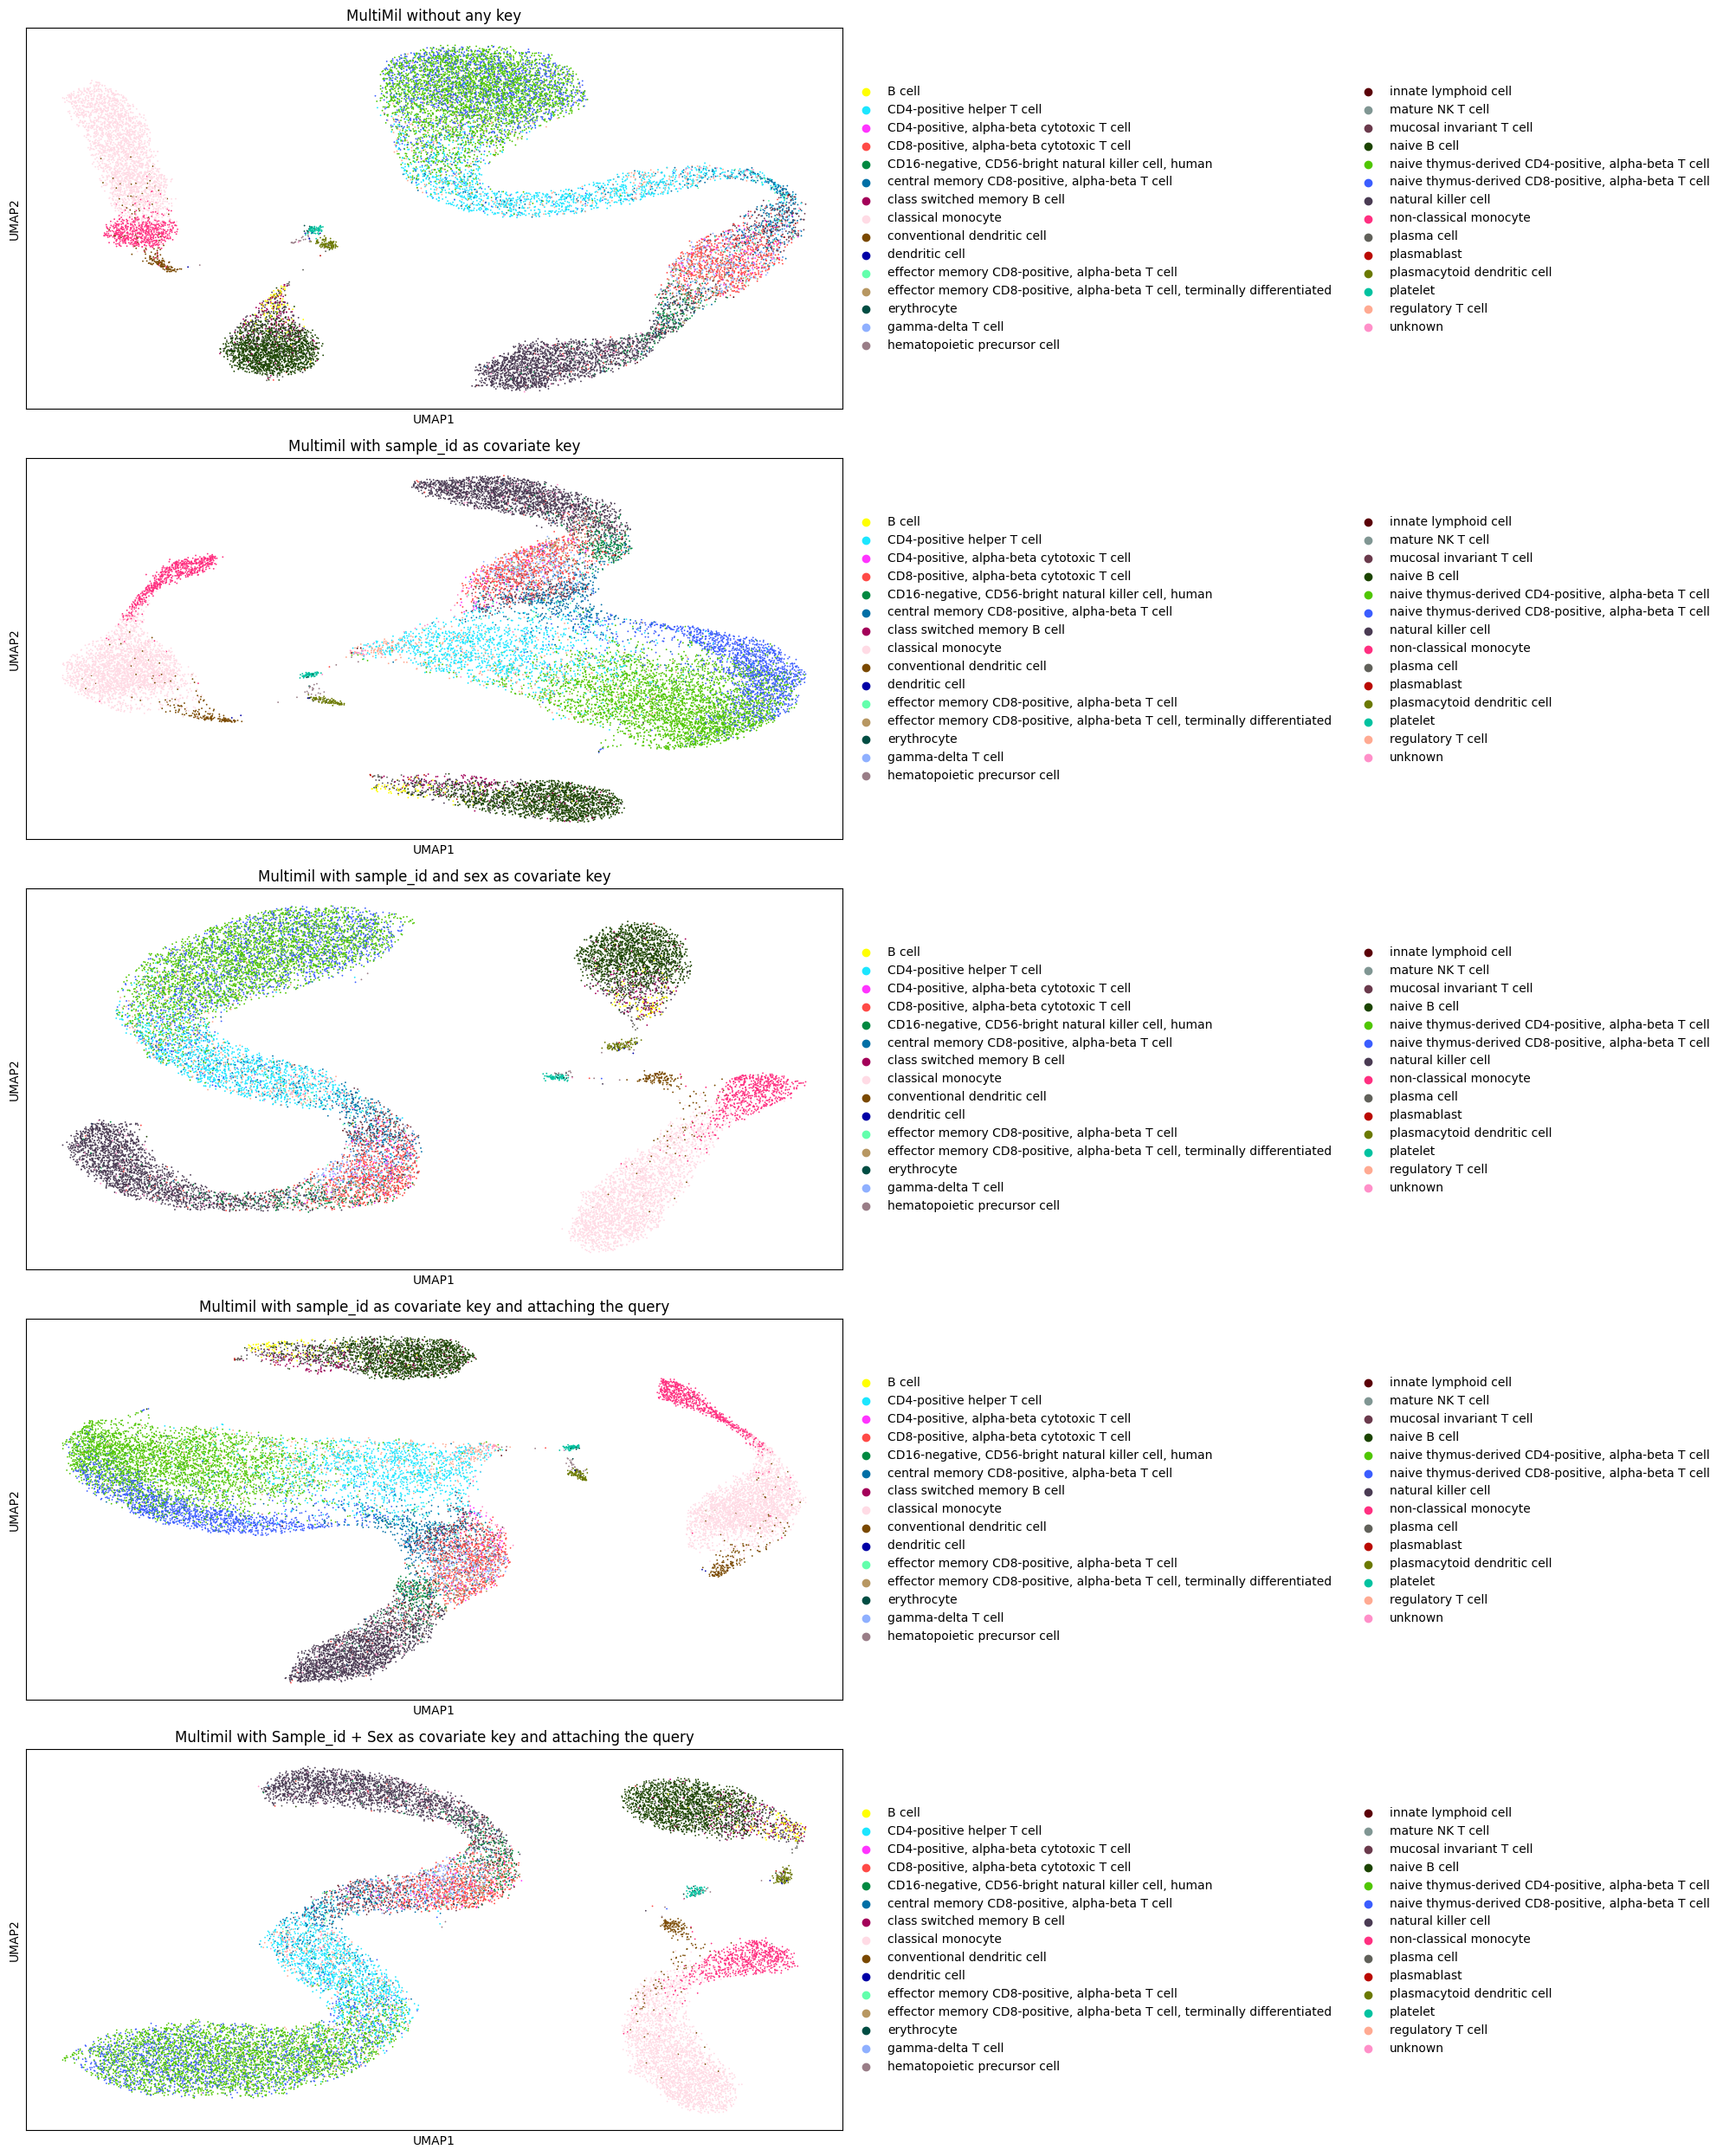

In [185]:
# Setup fig size and its orientation
fig, axes = plt.subplots(5, 1, figsize=(20, 25))

# First row
sc.pl.umap(adata_formatted, color="cell_type", show=False, ax=axes[0], 
           title="MultiMil without any key")

# Second row
sc.pl.umap(adata_formatted_sample, color="cell_type", show=False, ax=axes[1], 
           title="Multimil with sample_id as covariate key")

# Third row
sc.pl.umap(adata_formatted_sample_sex, color="cell_type", show=False, ax=axes[2], 
           title="Multimil with sample_id and sex as covariate key")
#fourth row
sc.pl.umap(adata_both_sample, color="cell_type", show=False, ax=axes[3], 
           title="Multimil with sample_id as covariate key and attaching the query")

# Fifth row
sc.pl.umap(adata_both_sample_sex, color="cell_type", show=False, ax=axes[4], 
           title="Multimil with Sample_id + Sex as covariate key and attaching the query")
# Adjust layout
plt.tight_layout()
plt.show()

In [186]:
new_vae_sample.adata

AnnData object with n_obs × n_vars = 1077 × 2000
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'cel

In [189]:
new_vae_sample_sex.adata

AnnData object with n_obs × n_vars = 1077 × 2000
    obs: 'dataset_id', 'observation_joinid', 'sample_id', 'cell_type', 'cell_type_ontology_term_id', 'sample_', 'assay', 'assay_ontology_term_id', 'cell_count', 'citation', 'collection_id', 'dataset_version_id', 'default_embedding', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'experiment___', 'explorer_url', 'feature_count', 'filesize', 'filetype', 'is_primary_data', 'mean_genes_per_cell', 'organism', 'organism_ontology_term_id', 'primary_cell_count', 'published_at', 'raw_data_location', 'revised_at', 'sample_heuristic', 'schema_version', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'title', 'tombstone', 'url', 'X_umap1', 'X_umap2', 'age_days', 'tissue_groups', 'atlas_id', 'cell_annotation_blueprint_singler', 'cell_annotation_monaco_singler', 'cel

In [187]:
new_vae_sample.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `MultiVAE.setup_anndata` with arguments:

{
│   'size_factor_key': None,
│   'rna_indices_end': 2000,
│   'categorical_covariate_keys': ['sample_id'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 1077  │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│      size_factor       │         adata.obs['size_factors']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                       extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃            Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_id'] │ 2ab8e9010d4ee13eafc3f891cb9df4e0 │          0          │
│                        │ 4c8846c46d4c5123bb1d569d8f65fb3b │          1          │
│                        │ 6d35f9d656a50dbb8009d5069ddbc8e2 │          2          │
│                        │ 7d1eca266fcde0b809aaa718b7bed893 │          3          │
│                        │ 9a3bde6c5a7c925cf4dff6c8b17fea3e │          4          │
│                        │ 9acbba567ddf904d2c33059430ea83ba │          5          │
│                        │ 53b18e8f9b9476afa8e43073241e80b1 │          6          │
│                        │ 136ad047fc2c3eb5346578d40cff2947 │          7          │
│                        │ ab8bbc52df887a48b399ce3cbc485aa5 │          8          │
│                        │ acf61c55fd68f3676b17f187aa108130 │          9          │
│                        │ b242dbe9a58fd9b9db5237b12a1d9bdc │         10          │
│                        │ b4683e7aff5e496be9e1782a1fc21aa8 │         11          │
│                        │ b4936c4fb1c818e510649118ba4c16ff │         12          │
│                        │ b26317effafb20b0d8c8a0a704ca8038 │         13          │
│                        │ cbc6acba4581aa259b0082a8f6b9b492 │         14          │
│                        │ cf8b6d5e72d68217680f117ab9f9e39f │         15          │
│                        │ ddc4114183b1dcc44a799a7b5bd34e6f │         16          │
│                        │ f12b4e0ee6584b3d46342f45f69e3d50 │         17          │
│                        │ 1c5b0fb1d172136c78e6e46a94fe59b9 │         18          │
│                        │                                  │                     │
└────────────────────────┴──────────────────────────────────┴─────────────────────┘

In [188]:
new_vae_sample_sex.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `MultiVAE.setup_anndata` with arguments:

{
│   'size_factor_key': None,
│   'rna_indices_end': 2000,
│   'categorical_covariate_keys': ['sample_id', 'sex'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 1077  │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   0   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│      size_factor       │         adata.obs['size_factors']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                       extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃            Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample_id'] │ 2ab8e9010d4ee13eafc3f891cb9df4e0 │          0          │
│                        │ 4c8846c46d4c5123bb1d569d8f65fb3b │          1          │
│                        │ 6d35f9d656a50dbb8009d5069ddbc8e2 │          2          │
│                        │ 7d1eca266fcde0b809aaa718b7bed893 │          3          │
│                        │ 9a3bde6c5a7c925cf4dff6c8b17fea3e │          4          │
│                        │ 9acbba567ddf904d2c33059430ea83ba │          5          │
│                        │ 53b18e8f9b9476afa8e43073241e80b1 │          6          │
│                        │ 136ad047fc2c3eb5346578d40cff2947 │          7          │
│                        │ ab8bbc52df887a48b399ce3cbc485aa5 │          8          │
│                        │ acf61c55fd68f3676b17f187aa108130 │          9          │
│                        │ b242dbe9a58fd9b9db5237b12a1d9bdc │         10          │
│                        │ b4683e7aff5e496be9e1782a1fc21aa8 │         11          │
│                        │ b4936c4fb1c818e510649118ba4c16ff │         12          │
│                        │ b26317effafb20b0d8c8a0a704ca8038 │         13          │
│                        │ cbc6acba4581aa259b0082a8f6b9b492 │         14          │
│                        │ cf8b6d5e72d68217680f117ab9f9e39f │         15          │
│                        │ ddc4114183b1dcc44a799a7b5bd34e6f │         16          │
│                        │ f12b4e0ee6584b3d46342f45f69e3d50 │         17          │
│                        │ 1c5b0fb1d172136c78e6e46a94fe59b9 │         18          │
│                        │                                  │                     │
│    adata.obs['sex']    │              female              │          0          │
│                        │               male               │          1          │
│                        │                                  │                     │
└────────────────────────┴──────────────────────────────────┴─────────────────────┘

## save the model and ann data object

In [191]:
vae.save(dir_path="/Users/gp/Desktop/MultiMil/saved_models/multimil",overwrite=True,save_anndata=True)
new_vae_sample.save(dir_path="/Users/gp/Desktop/MultiMil/saved_models/multimil_sample",overwrite=True,save_anndata=True)
new_vae_sample_sex.save(dir_path="/Users/gp/Desktop/MultiMil/saved_models/multimil_sample_sex",overwrite=True,save_anndata=True)